## TEDtalks_EDA analysis
#### Team: Yan Qiu, Ruixi Wang, Xin Zhao

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
import re
import string

In [17]:
def tokenize(doc):

    tokens = []
    stop_words = set(stopwords.words('english'))
    stop_words.update(['us','ve','nt','re','ll','wo','ca','m','s','t','``','...','-','—',' ','laughter','applause', 'ok', 'oh'])
    wordnet_lemmatizer = WordNetLemmatizer()

    def nltk_tag_to_wordnet_tag(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else: 
            #return default value
            return wordnet.NOUN

    tokens =[wordnet_lemmatizer.lemmatize(token.strip(), nltk_tag_to_wordnet_tag(tag)) \
            for token, tag in nltk.pos_tag(nltk.word_tokenize(doc.lower()))\
            if token.strip() not in stop_words and\
            token.strip() not in string.punctuation]
    
    t = []
    for token in tokens:        
        if len(token) <= 1:
            tokens.remove(token)
        elif len(token) >1:
            t.append(token)
                           
    return t

def compute_tfidf(docs):
    
    smoothed_tf_idf, smoothed_idf, words = None, None, None
         
    docs_tokens={idx:nltk.FreqDist(tokenize(doc)) \
             for idx,doc in enumerate(docs)}

    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index" )
    dtm=dtm.fillna(0)
    dtm=dtm.sort_index(axis=0)
    words = np.array(dtm.columns) 
       
    tf1=dtm.values
    doc_len=tf1.sum(axis=1)
    tf=np.divide(tf1.T, doc_len).T    
    df=np.where(tf>0,1,0)


    smoothed_idf = np.log(np.divide(len(docs)+1, np.sum(df, axis=0)+1))+1      
    
    smoothed_tf_idf = normalize(tf*smoothed_idf)
    
    return smoothed_tf_idf, smoothed_idf, words

def vectorize_doc(doc, words, idf):
    
    vect = None   
    
    tokens = tokenize(doc)

    tf1 = np.zeros(len(words))   

    for token in tokens:
        for idx, word in enumerate(words):
            if token == word:
                tf1[idx] = tokens.count(token)
               
    tf = np.expand_dims(tf1, axis=0) 
    idf = np.expand_dims(idf,axis=0)

    vect = normalize(tf*idf)
    
    return vect

def find_answer(doc_vect, tf_idf, docs):
    
    top_docs  = []
    
    
    similarity=1-pairwise_distances( doc_vect,tf_idf, metric = 'cosine')
       
    idx = np.argsort(similarity)[:,::-1][0,0:11]
    
    top_docs.append(docs[idx])
        
    return top_docs

### Load data and tokenize columns for text analysis

In [18]:
file = 'ted_talks_data_clean.csv'
    
df = pd.read_csv(file, engine='python')
    
token_speakers = tokenize(df.speakers.to_string(index=False))
token_topics = tokenize(df.topics.to_string(index=False))
token_descriptions = tokenize(df.descriptions.to_string(index=False))
token_tags = tokenize(df.tags.to_string(index=False).replace('|',',')) 

### TEDtalks data overview

In [33]:
df

,speakers,durations,topics,views,descriptions,tags,lengths,tags_,number_of_tags
0,James Veitch,588,This is what happens when you reply to spam email,63440723,Suspicious emails unclaimed insurance bonds di...,comedy|curiosity|communication|humor|technology,0:09:48,comedy curiosity communication humor technology,5
1,Amy Cuddy,1262,Your body language may shape who you are,59281283,NOTE Some of the findings presented in this ta...,body language|brain|business|psychology|self|s...,0:21:02,body language brain business psychology self s...,7
2,Simon Sinek,1084,How great leaders inspire action,52322192,Simon Sinek has a simple but powerful model fo...,|business|entrepreneur|leadership|success,0:18:04,business entrepreneur leadership success,5
3,Bren Brown,1219,The power of vulnerability,50616677,Bren Brown studies human connection our abili...,|communication|culture|depression|fear|mental ...,0:20:19,communication culture depression fear mental ...,9
4,Julian Treasure,598,How to speak so that people want to listen,44263258,Have you ever felt like youre talking but nobo...,culture|sound|speech,0:09:58,culture sound speech,3
...,...,...,...,...,...,...,...,...,...
995,Geoffrey Canada,1027,Our failing schools Enough is enough,2316155,Why why why does our education system look so ...,business|children|education,0:17:07,business children education,3
996,Christopher Soghoian,376,How to avoid surveillance with the phone in y...,2314557,Who is listening in on your phone calls On a l...,|government|security|technology|surveillance|e...,0:06:16,government security technology surveillance e...,6
997,Shashi Tharoor,1073,Why nations should pursue soft power,2310855,India is fast becoming a superpower says Shash...,business|culture|entertainment|global issues|i...,0:17:53,business culture entertainment global issues i...,7
998,James Zucker,167,How do you know you exist,2308989,How do you know youre real Is existence all ju...,philosophy|animation||self|exploration|brain|p...,0:02:47,philosophy animation self exploration brain p...,9


### The top 15 popular tags

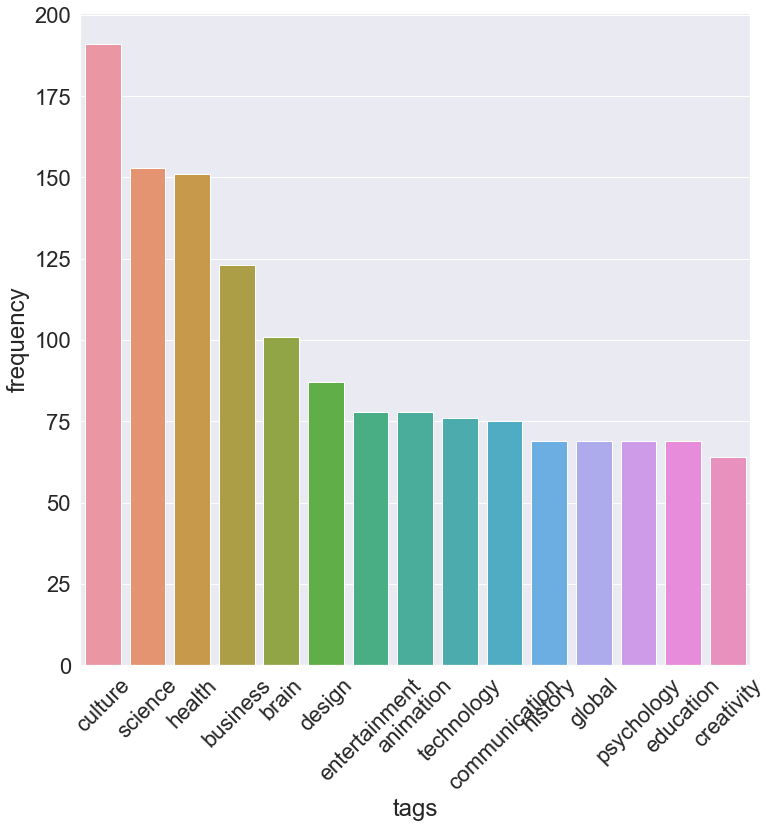

In [20]:
token_count = {token:token_tags.count(token) for token in set(token_tags)}  
tags = pd.DataFrame(list(token_count.items()),columns=['tags','frequency']).sort_values('frequency', ascending=False)[:15]
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
sns.set(font_scale = 2)
plt.figure(figsize=(12,12))
sns.barplot(x='tags', y='frequency', data=tags)
plt.xticks(rotation=45)
plt.show()

### Compute tfidf

In [21]:
df['tags_'] = df.tags.str.replace('|',' ')
docs = df.apply(lambda x: x["topics"] + "," + x["tags_"], axis = 1).reset_index(drop=True)
tf_idf, idf, words = compute_tfidf(docs)

def tag_recommendation(doc):
    vect = vectorize_doc(doc, words, idf)
    answers = find_answer(vect, tf_idf, docs)
    data = None
    for i in answers:
        data=list(zip(i))
    dt = pd.DataFrame(data=data)
    dt = dt[0].str.split(',', expand=True).rename(columns={0:'topics',1:'tags'})
    return dt

### Science Tag related topics recommendation

In [22]:
doc = 'science'
tag_recommendation(doc)

,topics,tags
0,How your brain decides what is beautiful,evolutionary psychology beauty brain cognitive...
1,The science of spiciness,animation science food history human body cul...
2,A theory of everything,cognitive science comedy entertainment humor p...
3,The surprising science of happiness,brain choice culture evolution happiness psych...
4,This is your brain on communication,brain cognitive science collaboration language...
5,Why do we sleep,health mental health neuroscience science cons...
6,Why we love why we cheat,cognitive science culture evolution gender lov...
7,The brain in love,brain cognitive science culture literature lov...
8,Why we laugh,cognitive science humor neuroscience science p...
9,Battling bad science,data health care illness illusion medicine sci...


### Culture Tag related topics recommendation

In [23]:
doc = 'culture'
tag_recommendation(doc)

,topics,tags
0,Where is home,culture happiness travel world cultures writing
1,The myth of Hercules,history culture world cultures death war
2,A brief history of cheese,food history animation culture world cultures
3,A brief history of alcohol,education animation history culture food worl...
4,Why is x the unknown,culture history language math
5,History vs Napoleon Bonaparte,history war animation world cultures culture ...
6,The fascinating history of cemeteries,history culture world cultures death
7,The history of Tea,anthropology history china world cultures cult...
8,The history of chocolate,anthropology design health history world cultu...
9,History through the eyes of a chicken,history culture world cultures food education...


### Health Tag related topics recommendation

In [24]:
doc = 'health'
tag_recommendation(doc)

,topics,tags
0,The voices in my head,health health care mental health
1,Debunking the myths of OCD,health personality psychology mental health h...
2,How do carbohydrates impact your health,health health care public health healthcare fo...
3,What causes headaches,health public health mental health brain biolo...
4,What causes cavities,health public health healthcare animation hea...
5,Why do we itch,health psychology public health human body ani...
6,Is it bad to hold your pee,health public health human body physiology an...
7,How stress affects your body,consciousness health psychology human body an...
8,The benefits of good posture,design health public health technology animat...
9,How sugar affects the brain,health brain food health care healthcare anim...


### Topics Word Cloud

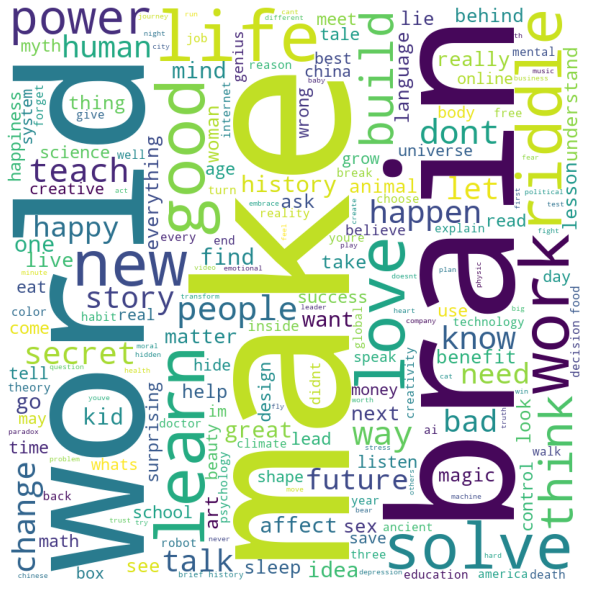

In [25]:
token_topics_string = ' '.join([str(elem) for elem in token_topics]) 
wordcloud = wordcloud.WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(token_topics_string)
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Most Viewed Talks and speakers

,topics,speakers,views,lengths,tags
35,Do schools kill creativity,Sir Ken Robinson,68355856,0:19:24,children|creativity|culture|dance|education|pa...
0,This is what happens when you reply to spam email,James Veitch,63440723,0:09:48,comedy|curiosity|communication|humor|technology
1,Your body language may shape who you are,Amy Cuddy,59281283,0:21:02,body language|brain|business|psychology|self|s...
2,How great leaders inspire action,Simon Sinek,52322192,0:18:04,|business|entrepreneur|leadership|success
3,The power of vulnerability,Bren Brown,50616677,0:20:19,|communication|culture|depression|fear|mental ...


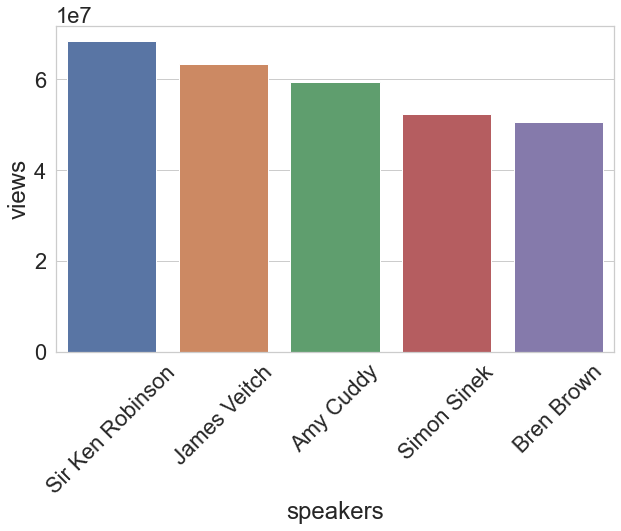

In [26]:
pop_talks = df[['topics', 'speakers', 'views', 'lengths','tags']].sort_values('views', ascending=False)[:5]
#Visualize most popular speakers 
pop_talks['speakers'] = pop_talks['speakers'].apply(lambda x: x[:16])
sns.set_style("whitegrid")
sns.set_color_codes("pastel")
plt.figure(figsize=(10,6))
plt.xticks(rotation=45)
sns.barplot(x='speakers', y='views', data=pop_talks)

pop_talks

### All topics naive sentiment analysis

In [27]:
# positive
with open("positive-words.txt",'r') as f_po:
    positive_words=[word.strip() for word in f_po]   
positive_tokens_topic=[token for token in token_topics if token in positive_words]

# negative
with open("negative-words.txt",'r') as f_ne:
    negative_words=[word.strip() for word in f_ne]   
negative_tokens_topic=[token for token in token_topics if token in negative_words]


print('count of positive word in topics:',len(positive_tokens_topic))
print('count of negative word in topics:',len(negative_tokens_topic))

count of positive word in topics: 347
count of negative word in topics: 299


### All descriptions naive sentiment analysis

In [28]:
positive_tokens_desc=[token for token in token_descriptions if token in positive_words]
negative_tokens_desc=[token for token in token_descriptions if token in negative_words]


print('count of positive word in descriptions:',len(positive_tokens_desc))
print('count of negative word in descriptions:',len(negative_tokens_desc))

count of positive word in descriptions: 297
count of negative word in descriptions: 229


### Top 500 popular talks naive sentiment analysis

In [34]:
df_t500 = df.sort_values(by=['views'],ascending=False)[:501]
 

with open("positive-words.txt",'r') as f_po:
    positive_words=[word.strip() for word in f_po]  
    
with open("negative-words.txt",'r') as f_ne:
    negative_words=[word.strip() for word in f_ne]   

    
token_topics_t500 = tokenize(df_t500.topics.to_string(index=False).replace('...',''))
token_descriptions_t500 = tokenize(df_t500.descriptions.to_string(index=False))

positive_topic=[token for token in token_topics_t500 if token in positive_words]
negative_topic=[token for token in token_topics_t500 if token in negative_words]

print('count of positive word in topics:',len(positive_topic))
print('count of negative word in topics:',len(negative_topic))

positive_desc=[token for token in token_descriptions_t500 if token in positive_words]
negative_desc=[token for token in token_descriptions_t500 if token in negative_words]

print('count of positive word in descriptions:',len(positive_desc))
print('count of negative word in descriptions:',len(negative_desc))

count of positive word in topics: 191
count of negative word in topics: 155
count of positive word in descriptions: 158
count of negative word in descriptions: 110


### The correlation between the number of views and the number of tags

,number_of_tags,views
number_of_tags,1.000000,-0.072501
views,-0.072501,1.000000


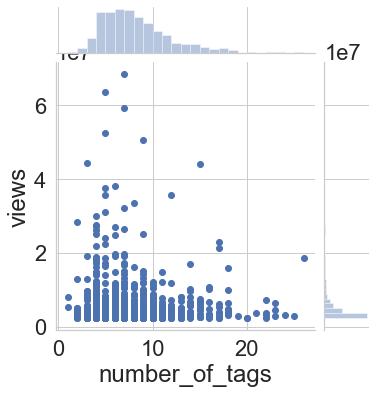

In [29]:
df['number_of_tags'] = df['tags'].apply(lambda x: len(x.split('|')))
sns.jointplot(x='number_of_tags', y='views', data=df)
df[['number_of_tags', 'views']].corr()

### The correlation between the number of views and the duration of speech

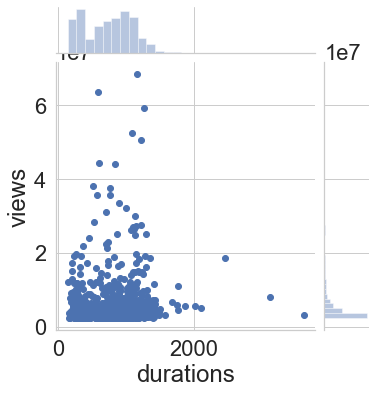

In [30]:
sns.jointplot(x='durations', y='views', data=df) #use second unit of durations
plt.show()